# Floor visualization

Here, we are going to calculate the physical distance from any sampled point to the floor.
This will be testing to see the link between spatial distances and microbial / metabolomic profiles.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skbio.stats.distance import DistanceMatrix
from skbio.stats.composition import closure, ilr, multiplicative_replacement, centralize, clr
from biom import load_table
from gneiss.sort import niche_sort
from gneiss.util import match
%matplotlib inline

We'll load up the metadata and the OTU and MS feature tables.

In [2]:
data_dir = '../data'
otu_table = load_table('%s/deblur-clean-16s.biom' % data_dir)
mapping = pd.read_csv('%s/qiita_refined_mapping.csv' % data_dir, index_col=0)
ms_table = load_table('%s/MS1.biom' % data_dir)

otu_table = pd.DataFrame(np.array(otu_table.matrix_data.todense()).T,
                         index=otu_table.ids(axis='sample'),
                         columns=otu_table.ids(axis='observation'))
ms_table = pd.DataFrame(np.array(ms_table.matrix_data.todense()).T,
                        index=ms_table.ids(axis='sample'),
                        columns=ms_table.ids(axis='observation'))

floor_mapping = mapping.loc[mapping.sample_site=='Floor']

Now we'll want to estimate the 3D plane that intersects the floor.  To do so, we'll only extract the floor points, and estimate this plane using the top 2 axes in PCA.

In [3]:
u, s, v = np.linalg.svd(floor_mapping[['x','y','z']].values)
m = u[:, :3].dot(np.diag(s))

This is to measure the height through the 3rd axis.  Basically investigating how trustworthy this fit is.  As you can see, the there isn't too much variance in the height.

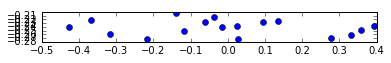

In [4]:
from mpl_toolkits.mplot3d import Axes3D
fig, ax = plt.subplots()
#ax = fig.add_subplot(111, projection='3d')
ax.plot(u[:,1], u[:, 0], 'ob')
#ax.plot(floor_mapping.y, floor_mapping.z, 'ob')
ax.set_aspect('equal')

Now let's only look at the top 2 eigenvectors and see how they are distributed spatially.

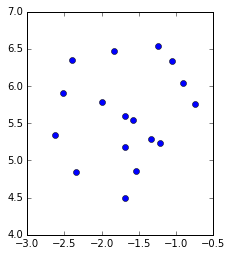

In [5]:
fig, ax = plt.subplots()
ax.plot(floor_mapping.x, floor_mapping.y, 'ob')
ax.set_aspect('equal')

Looking good!  Now we can use this plane to transform all of the points to make the floor the reference.
Ultimately, this will be rotating the coordinate system, so that the floor is flat on the bottom,
as we are normally used it.

In [6]:
x = floor_mapping[['x', 'y', 'z']].values

# perform linear transformation to find rotation matrix
# since u = x.dot(A)
A = np.linalg.pinv(x).dot(u[:, :3])

t = x.dot(A)

Now just to sanity check to see how this transformation worked out.

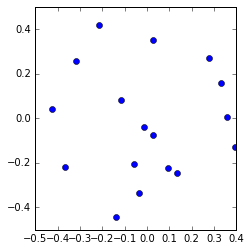

In [7]:
from mpl_toolkits.mplot3d import Axes3D
fig, ax = plt.subplots()
ax.plot(t[:,1], t[:, 2], 'ob')
ax.set_aspect('equal')

Now we will transform the rest of the points using this linear transformation.

In [8]:
coords = mapping[['x', 'y', 'z']]
k = coords.dot(A)
k.columns = ['cx', 'cy', 'cz']

And we'll save the transformed mapping to disk.

In [9]:
tmapping = pd.merge(mapping, k, left_index=True, right_index=True)
tmapping.to_csv('../data/transformed_mapping.csv')

Let's do another sanity check to see how our transformation worked.
Now, we'll just plot the height for each of the samples.

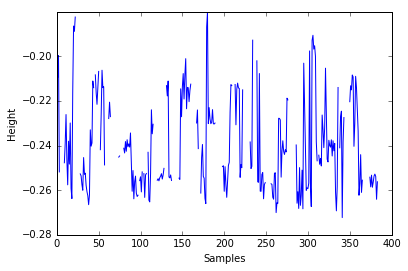

In [10]:
plt.plot(tmapping.cx.values)
plt.ylabel('Height')
plt.xlabel('Samples')

Ok, its a little off. We'll fix the scaling and offset in a bit.  But first let's clean up the data a little bit, namely removing duplicating and nans.

In [11]:
floor_distance = tmapping.cx
floor_distance = floor_distance.drop_duplicates()
floor_distance = floor_distance.dropna()

Now we'll see how the OTUs stratify across the spatial height.  Now we'll want to scale the 
height to match the actual spatial height.

In [12]:
scaled_floor_distance = ((floor_distance - floor_distance.min()) * 50).astype(np.int)

otu_table, otu_floor_distance = match(otu_table, scaled_floor_distance)

sorted_table = niche_sort(otu_table, otu_floor_distance)

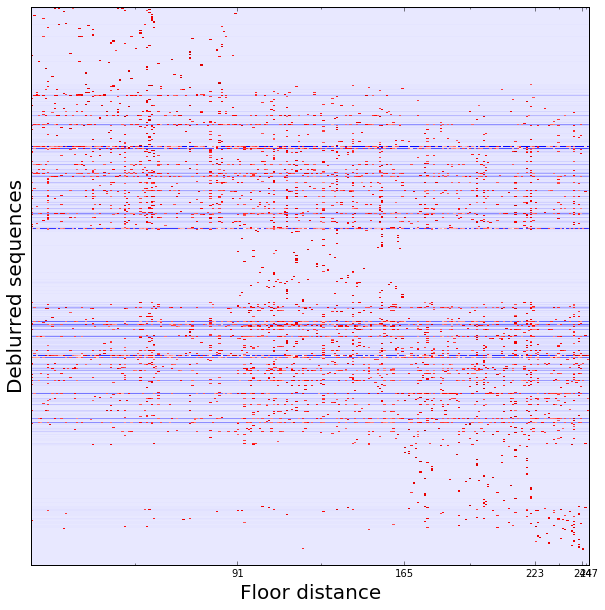

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(clr(sorted_table.values.T+0.01), 
          aspect='auto', interpolation='nearest', cmap='seismic')
ax.set_yticks([])
ax.set_xticks([])

ax.set_xlabel('Floor distance', fontsize=20)
ax.set_ylabel('Deblurred sequences', fontsize=20)
ticks = otu_floor_distance.value_counts().sort_index().cumsum()
midpoints = ticks - (ticks - np.array([0] + list(ticks.values[:-1]))) / 2.0
_=ax.set_xticks(ticks.values, minor=False)
_=ax.set_xticks(midpoints, minor=True)

In [14]:
ms_table = ms_table.dropna()

In [15]:
ms_table, ms_floor_distance = match(ms_table, scaled_floor_distance)
sorted_table = niche_sort(ms_table, ms_floor_distance)

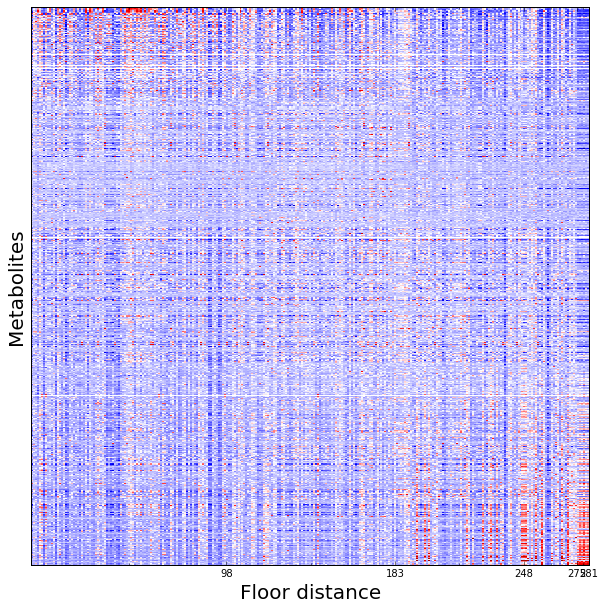

In [16]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(clr(sorted_table.values.T), 
          aspect='auto', interpolation='nearest', cmap='seismic')
ax.set_ylabel('Metabolites', fontsize=20)
ax.set_yticks([])
ax.set_xlabel('Floor distance', fontsize=20)
ticks = ms_floor_distance.value_counts().sort_index().cumsum()
midpoints = ticks - (ticks - np.array([0] + list(ticks.values[:-1]))) / 2.0
_=ax.set_xticks(ticks.values, minor=False)
_=ax.set_xticks(midpoints, minor=True)